In [1]:
import os, sys, inspect

currentdir = os.path.dirname(os.path.abspath(os.path.join(inspect.getfile(inspect.currentframe()), os.pardir)))
currentdir = os.path.join(currentdir , "src")
sys.path.insert(0, currentdir)

import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import os
import img_logger
import utils
from os import listdir
from os.path import isfile, join
import color_analyser as ca

import logging

logging.basicConfig(level=logging.INFO)

plt.rcParams['figure.figsize'] = [30, 30]
path_data = "..\input"
network_path = os.path.join("config", "frozen_east_text_detection.pb")
pictures = [f for f in listdir(path_data) if isfile(join(path_data, f))]


In [2]:
## test img
def get_white_rgb(size):
    img = np.uint8(np.full(size, 255))
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

def get_test_img():
    img = get_white_rgb((500, 500))

    # draw xy
    img = img_logger.draw_lines([(50, 0)], img, (0, 0, 0))
    img = img_logger.draw_lines([(440, np.pi / 2)], img, (0, 0, 0))

    # draw f1
    img = img_logger.draw_lines([(400, np.pi / 4)], img, (255, 0, 0))

    # draw f2
    img = img_logger.draw_lines([(200, np.pi / 7)], img, (0, 255, 0))
    
    return img



## Test count of distinct colors

Algorithm works as follows

1. Compute
  1. Peaks on the histogram - this works perfect for perfectly sharp images
  2. Peaks and their k-means(k=2) - this works fine for images blurred images
  3. Peaks and their relative values - it takes top k colors that creates more than `x`% of the image - experimental
2. return median of those three values (despite there are too few to make a use of it)

The first example shows a picture with artifical image which is ideally sharp, the second shows a real pictures from web.

INFO:color_analyser:peaks found 4 color
INFO:color_analyser:peaks_kmeans found 2 color
INFO:color_analyser:marginal found 4 color
INFO:color_analyser:color election [4 2 4]
INFO:color_analyser:median 4


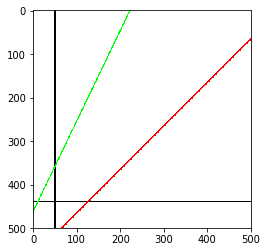

In [3]:
# example 1
img=get_test_img()
plt.imshow(img)
count=ca.get_color_count(img)
#print("this picture has {} colors".format(count))


In [4]:
#example2 

# anotated images (file_name, expected_color_count)
data = [('artifical.png', 4),
        ('f1.png', 4), ('f2.png', 5), ('f3.png', 4), ('f4.png', 4), ('f5.png', 9), ('ff.png', 4),
        ('ff3b013d29857f952535c3949fe9e892.jpg', 6), ('ff_adsfga.PNG', 4), ('ff_asdfannl.PNG', 3), ('f_3.png', 4),
        ('lc_1.png', 4), ('maxresdefault.jpg', 5), ('p1.jpg', -1), ('p2.jpg', -1), ('p3.jpg', -1), ('panda.jpg', -1),
        ('picture4.jpg', 6), ('picture5.jpg', 4), ('picture51.jpg', 6), ('TC-TR-Normal.jpg', 2), ('th.jpg', 4),
        ('tst_1.png', 2)]


def calc_hist_gs(p):
    gray = cv2.cvtColor(cv2.imread(os.path.join(path_data, p)), cv2.COLOR_RGB2GRAY)
    histr = cv2.calcHist([gray], [0], None, [256], [0, 256])

    return np.float32(np.array([int(x[0]) for x in histr]))  # / img.size

def test_results(data, fun):
    
    # pairs of calculated and expected
    res = [(fun(calc_hist_gs(p)), e) for p, e in data if e > 0]

    def q_dist(res, exp):
        return (res - exp) ** 2

    dists = [q_dist(r, e) for r, e in res]
    
    # quadratic distance and pair of calculated and expected
    dis_res = list(zip(dists, res))
    sm = sum([q_dist(r, e) for r, e in res])
    
    return dis_res, sm


dst_exp, sm_sq = test_results(data, ca.get_color_count_peaks_only)
print("Peaks only Error: {}\nData: {}".format(sm_sq, dst_exp))

dst_exp, sm_sq = test_results(data, ca.get_color_count_peaks_kmeans)
print("Peak Kmeans: {}\nData: {}".format(sm_sq, dst_exp))

dst_exp, sm_sq = test_results(data, ca.get_color_count_peaks_marginal)
print("Marginal Error: {} \nData: {}".format(sm_sq, dst_exp))


Peaks only Error: 111
Data: [(0, (4, 4)), (1, (5, 4)), (0, (5, 5)), (9, (7, 4)), (49, (11, 4)), (9, (6, 9)), (1, (3, 4)), (9, (9, 6)), (9, (1, 4)), (9, (6, 3)), (0, (4, 4)), (0, (4, 4)), (1, (6, 5)), (1, (5, 6)), (4, (6, 4)), (1, (7, 6)), (4, (4, 2)), (4, (2, 4)), (0, (2, 2))]
Peak Kmeans: 161
Data: [(4, (2, 4)), (0, (4, 4)), (9, (2, 5)), (4, (2, 4)), (1, (3, 4)), (36, (3, 9)), (4, (2, 4)), (16, (2, 6)), (16, (0, 4)), (1, (2, 3)), (1, (3, 4)), (4, (2, 4)), (9, (2, 5)), (16, (2, 6)), (4, (2, 4)), (16, (2, 6)), (0, (2, 2)), (16, (0, 4)), (4, (0, 2))]
Marginal Error: 111 
Data: [(0, (4, 4)), (1, (5, 4)), (0, (5, 5)), (9, (7, 4)), (49, (11, 4)), (9, (6, 9)), (1, (3, 4)), (9, (9, 6)), (9, (1, 4)), (9, (6, 3)), (0, (4, 4)), (0, (4, 4)), (1, (6, 5)), (1, (5, 6)), (4, (6, 4)), (1, (7, 6)), (4, (4, 2)), (4, (2, 4)), (0, (2, 2))]


## Create mask using laplacian edge detector

The goal is find edges which are supposed to be the lines and use it as a mask to filter out blurred line.

1. Find eges on image using laplacian
2. Threshold image with edges
3. Combine it with original image
4. [Open,close morpohology operations does not help]

Does not work. Laplacian did not find proper lines and morphology creates more artifacts than it removes.


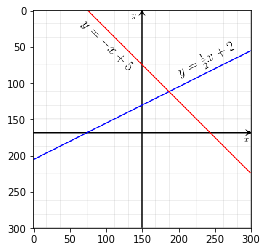

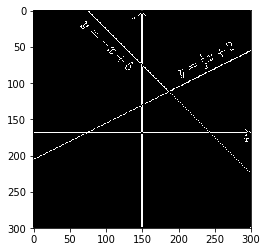

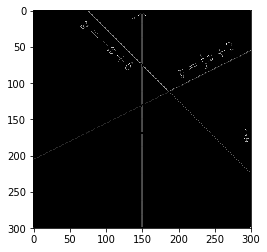

In [27]:
# create mask usin laplacian
pic = os.path.join(path_data, "f2.png")
img = cv2.imread(pic)

# find edges
gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
laplacian = cv2.Laplacian(gs, cv2.CV_64F)

# threshold
thr = (np.max(laplacian) + np.min(laplacian)) / 2
laplacian[laplacian <= thr] = 0
laplacian[laplacian > thr] = 1

masked_image = gs * laplacian

for img in [img, laplacian, masked_image]: 
    plt.imshow(img,cmap="gray")
    plt.show()


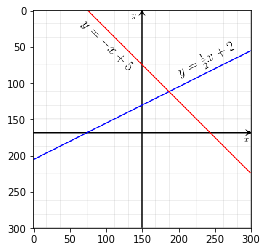

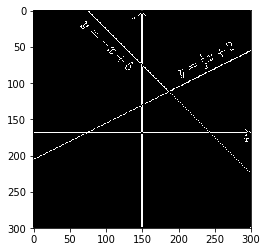

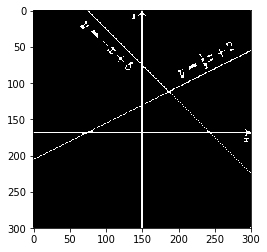

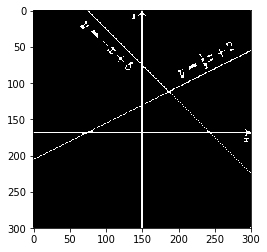

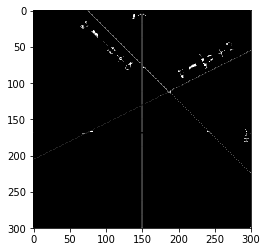

In [28]:
## Laplacian edge mask with morphology

# create mask usin laplacian
pic = os.path.join(path_data, "f2.png")
img = cv2.imread(pic)

# find edges
gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
laplacian = cv2.Laplacian(gs, cv2.CV_64F)

# threshold
thr = (np.max(laplacian) + np.min(laplacian)) / 2
laplacian[laplacian <= thr] = 0
laplacian[laplacian > thr] = 1
laplacian = np.uint8(laplacian)
kernel = np.ones((3, 3), np.uint8)

opening = cv2.morphologyEx(laplacian.copy(), cv2.MORPH_CLOSE, kernel)
closing = cv2.morphologyEx(opening.copy(), cv2.MORPH_CLOSE, kernel)

masked_image = gs * opening


for img in [img, laplacian, opening, closing, masked_image]:
    plt.imshow(img,cmap="gray")
    plt.show()

## Sharpening

Goal of sharpening is to reduce amount of color.

In result: it creates some artifacts on grayscale, especially on line intersections.(example1)

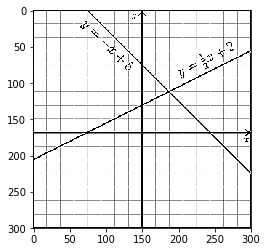

In [6]:
# example 1
# sharpening artifacts
pic = os.path.join(path_data, "f2.png")
img = cv2.imread(pic)
gs = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
im = cv2.filter2D(gs, -1, kernel)
histr = cv2.calcHist([im], [0], None, [256], [0, 256])
#cv2.imwrite("foo.png", im)
plt.imshow(im, cmap='gray')
plt.show()